In [32]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import seaborn as sns
import numpy as np

In [37]:
train_df = pd.read_csv("./train.csv").assign(sample = 'train')

test_df = pd.read_csv("./test.csv").assign(sample = 'test')

df = pd.concat([train_df, test_df]).sample(frac=1, random_state=13)

orig_features = df.drop(columns=['sample', 'id', 'price']).columns

In [38]:
train_df.corr()['price'].sort_values()

garage              -0.120137
basement            -0.034940
cityPartRange       -0.009366
hasGuestRoom        -0.009309
numPrevOwners       -0.008546
id                  -0.008060
attic               -0.006851
hasYard             -0.002545
hasStorageRoom       0.001567
hasPool              0.006023
isNewBuilt           0.008080
hasStormProtector    0.020512
cityCode             0.021986
made                 0.024270
floors               0.038374
numberOfRooms        0.091681
squareMeters         0.591749
price                1.000000
Name: price, dtype: float64

In [86]:
train_df[train_df.price < train_df.price.quantile(0.5)].corr()['price']

id                  -0.013503
squareMeters         0.980145
numberOfRooms       -0.033738
hasYard             -0.012193
hasPool              0.015044
floors               0.027572
cityCode            -0.016495
cityPartRange        0.016624
numPrevOwners        0.017042
made                -0.012461
isNewBuilt           0.002711
hasStormProtector    0.013532
basement             0.004077
attic               -0.019042
garage              -0.052888
hasStorageRoom       0.009794
hasGuestRoom        -0.033718
price                1.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='squareMeters', ylabel='price'>

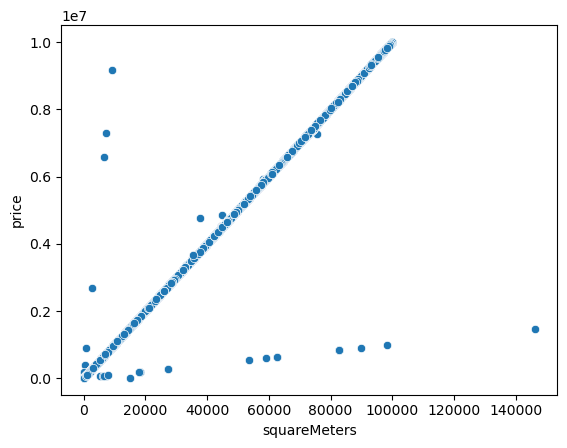

In [91]:
sns.scatterplot(data=train_df.query("squareMeters < 5e6"), x='squareMeters', y='price')

In [92]:
from sklearn.linear_model import LinearRegression

In [97]:
mod = LinearRegression()
linear_line = train_df.query("squareMeters < 5e6")
mod.fit(pd.DataFrame(linear_line['squareMeters']), linear_line['price'].values)

LinearRegression()

In [101]:
mod.coef_

array([99.77463739])

In [102]:
df['predict_price'] = df['squareMeters']*100

In [105]:
df['deviation'] = (df['predict_price'] - df['price'])/df['price']

In [113]:
df.sort_values('deviation').dropna().head(n=8)

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,...,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,sample,predict_price,deviation
5849,5849,180,87,0,0,86,86859,2,5,2000,...,1,6294,7379,416,1,0,181859.1,train,18000,-0.901022
9663,9663,380,86,1,1,81,96283,10,7,2000,...,0,5131,7793,411,0,8,383898.1,train,38000,-0.901015
2047,2047,900,4,0,0,96,51301,2,4,2000,...,1,6346,6571,251,1,3,902785.2,train,90000,-0.900309
20597,20597,176,41,0,1,50,73100,6,6,2009,...,1,6476,2696,625,1,8,176425.9,train,17600,-0.900241
7887,7887,6585,45,0,1,7,67796,9,10,2017,...,0,6018,6662,674,0,3,6587835.7,train,658500,-0.900043
7100,7100,9179,26,0,0,49,83574,8,1,2006,...,1,5931,4428,497,1,5,9179791.6,train,917900,-0.900009
4560,4560,7310,50,0,0,47,70353,5,10,2005,...,0,9675,6386,652,0,7,7306250.5,train,731000,-0.899949
20753,20753,2676,67,0,0,46,19556,5,3,2020,...,1,5351,8216,369,1,8,2672589.1,train,267600,-0.899872


In [115]:
train_df.sort_values('numberOfRooms')

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,sample
6901,6901,43189,1,0,0,32,22459,8,6,1997,1,1,8886,4326,793,0,6,4326117.0,train
9073,9073,63320,1,0,0,99,267,6,4,1993,0,1,1051,8217,125,1,8,6338701.3,train
2662,2662,89089,1,0,0,86,23882,7,3,2007,1,1,2174,4578,309,1,6,8914578.7,train
14350,14350,21394,1,1,1,44,24349,4,7,2017,0,0,3114,1845,982,0,5,2141175.7,train
8013,8013,14194,1,0,1,73,1906,7,5,2003,0,1,2677,9249,785,1,9,1429956.3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17641,17641,73140,100,1,1,73,84617,8,3,2019,1,1,7608,7849,691,1,9,7325048.9,train
8611,8611,21698,100,1,0,7,89782,4,3,2016,0,1,8776,8929,580,1,10,2173491.6,train
5596,5596,51490,100,0,0,44,76775,9,5,1998,0,1,8113,4975,826,0,10,5157896.8,train
2679,2679,56812,100,0,0,22,56534,5,3,2013,0,0,8512,4708,881,0,6,5683565.3,train


In [28]:
def objective(trial):
    """Define the objective function"""

    params = {
        #'gpu_id':0,
        #max_bin': trial.suggest_int('max_bin', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 15000),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 0.1),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1),
        'eval_metric': 'rmse',
        #'num_class': num_classes,
        #'objective':'multi:softmax',
        'seed':13,
    }


    cv = KFold(10, shuffle=True, random_state=13)
    fold_scores = []
    for i, (train_idx,val_idx) in enumerate(cv.split(train[features],train[target])):
        X_train, y_train = train.loc[train_idx, features],train.loc[train_idx, target]
        X_val, y_val = train.loc[val_idx, features],train.loc[val_idx, target]
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_train,
                 y_train,
                 eval_set= [(X_val,y_val)],
                 verbose=0, 
                  early_stopping_rounds=500)
        
        
        pred_val = model.predict(X_val)
        pred_test = model.predict(test[features])

        score = np.sqrt(mean_squared_error(y_val, pred_val))
        fold_scores.append(score)

    return np.mean(fold_scores)


In [29]:
features = ['squareMeters', 'garage']

In [73]:
train = df.query("sample == 'train'").drop(columns=['sample']).copy()
X_train = train[features]
y_train = train['price']

test_df = df.query("sample == 'test'").drop(columns=['sample']).copy()
test_df = test_df[features + ['id']]
test = test_df.reset_index(drop=True)
target = 'price'

In [35]:
study = optuna.create_study(direction='minimize', sampler = TPESampler())
study.optimize(objective, n_trials=25)

[I 2023-02-12 13:58:48,846] A new study created in memory with name: no-name-35b1fbb3-038a-4229-b5df-7b8a2db8cc31
[I 2023-02-12 14:00:13,174] Trial 0 finished with value: 170518.34724909588 and parameters: {'max_depth': 19, 'learning_rate': 0.45343173823866545, 'n_estimators': 11140, 'reg_lambda': 0.03402725739575318, 'gamma': 0.7739909012065234, 'subsample': 0.6051002581126503, 'colsample_bytree': 0.6115777789005895, 'min_child_weight': 6, 'reg_alpha': 0.06709848164254584}. Best is trial 0 with value: 170518.34724909588.
[I 2023-02-12 14:02:08,208] Trial 1 finished with value: 171481.66733245493 and parameters: {'max_depth': 13, 'learning_rate': 0.046929190449200756, 'n_estimators': 6520, 'reg_lambda': 0.07930719784175569, 'gamma': 0.9421736771710918, 'subsample': 0.5475702474004615, 'colsample_bytree': 0.9235278446645107, 'min_child_weight': 6, 'reg_alpha': 0.4772968230066442}. Best is trial 0 with value: 170518.34724909588.
[I 2023-02-12 14:03:19,755] Trial 2 finished with value: 16

In [67]:
test_df.query("sample == 'test'")

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,sample
0,22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8,test
1,22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4,test
2,22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2,test
3,22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5,test
4,22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15149,37879,86184,74,1,1,73,14009,2,10,1993,1,0,3714,3894,665,1,1,test
15150,37880,45885,41,1,1,64,84208,4,5,2008,0,0,783,7628,976,0,0,test
15151,37881,73554,51,0,0,41,49263,10,5,2004,0,1,8207,1777,775,0,10,test
15152,37882,77604,51,0,1,33,67056,4,3,2019,0,0,9578,9706,135,0,2,test


In [75]:
def run_results(param_input):
    test_md = test.copy()

    X = train[features]
    Y = train['price'] 

    test_data = test[features]

    XGB_cv_scores, XGB_imp = list(), list()
    preds = list()

    skf = KFold(10, random_state = 13, shuffle = True)

    for train_ix, test_ix in skf.split(X, Y):

        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        ## Building RF model
        XGB_md = xgb.XGBRegressor(**param_input).fit(X_train, Y_train,
                                               eval_set= [(X_test,Y_test)],
                             verbose=0, 
                              early_stopping_rounds=1000)

        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_data)

        ## Computing roc-auc score
        XGB_cv_scores.append(np.sqrt(mean_squared_error(Y_test, XGB_pred_1)))
        preds.append(XGB_pred_2)

    #XGB_cv_score = np.mean(XGB_cv_scores)    
    print('The average RMSE over 10-folds is:', np.mean(XGB_cv_scores))
    
    return pd.DataFrame(preds)

In [76]:
out_df = run_results(study.best_params)

The average RMSE over 10-folds is: 150455.88789855764


In [78]:
submission_file = pd.DataFrame(np.transpose(np.vstack([test_df['id'].astype('int'), pd.DataFrame(out_df).mean(axis=0)])), columns=['id', 'price'])
submission_file['id'] = submission_file['id'].astype('int')
submission_file.to_csv("./submissions/1.csv", index=False)

| Feature Set | Tuned Hyperparameters | CV (10-fold) Score | LB Score |
|---|---|---|---|
| squareMeters + garage | {'max_depth': 6, 'learning_rate': 0.86784166174935, 'n_estimators': 7576, 'reg_lambda': 0.08529109093613907, 'gamma': 0.8027899288145359, 'subsample': 0.5245578038004254, 'colsample_bytree': 0.19604135486059435, 'min_child_weight': 0, 'reg_alpha': 0.7188951178580443} | 150,455.88789855764| 186,205.05224 |
